In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df_for_training = pd.read_csv("avgp_total.csv")

In [33]:
df_for_training.head()

,AVGT,AVGP,MAXP,MINP,MINT,MAXT,MINU,avgp_imf5
0,165,10166,10195,10128,127,204,24,68.135283
1,148,10172,10191,10148,117,203,28,69.192951
2,155,10147,10176,10118,118,216,23,70.242387
3,172,10094,10124,10071,134,232,48,71.280462
4,199,10065,10085,10050,181,229,67,72.304737


In [4]:
imf = pd.read_csv("./Data/IMFs/avg_p_imf.csv")

In [6]:
imf.head(2)

,AVGP,imf_1,imf_2,imf_3,imf_4,imf_5,imf_6,imf_7
0,10166,53.590194,0.626524,-9.529219,0.147563,68.135283,2.599109,10050.430546
1,10172,59.780683,-1.048248,-8.733740,-0.224796,69.192951,2.601916,10050.431235


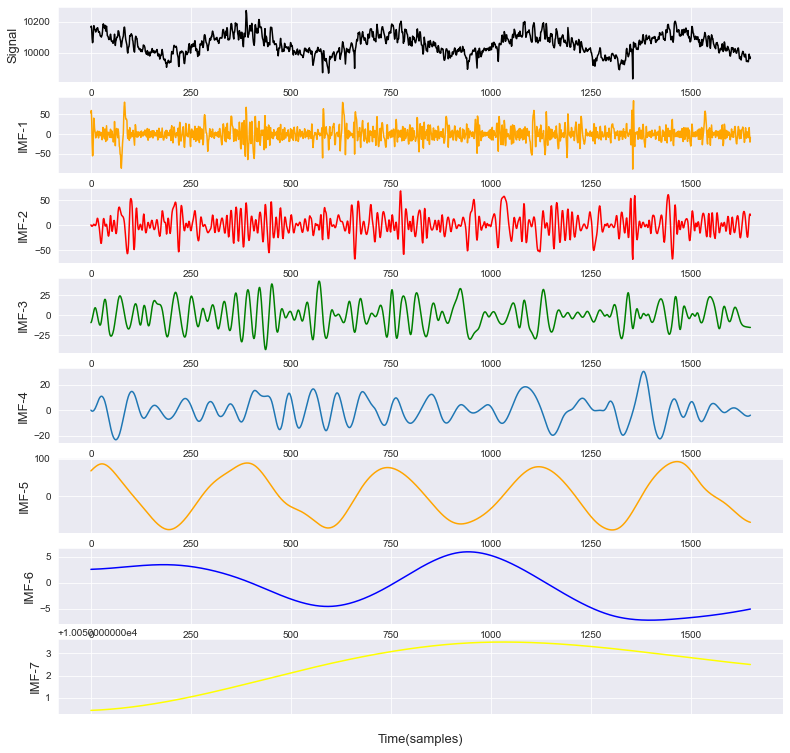

In [28]:
sns.set_style("darkgrid")
fig,(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(nrows=8,ncols=1,figsize=(13,13),label=["signal"])
plt.xticks(color="white")
plt.xlabel("Time(samples)",fontsize=13)
ax0.plot(imf.AVGP,color='black')
ax0.set_ylabel("Signal",fontsize=13)
ax1.plot(imf.imf_1,color='orange')
ax1.set_ylabel("IMF-1",fontsize=13)
ax2.plot(imf.imf_2,color='red')
ax2.set_ylabel("IMF-2",fontsize=13)
ax3.plot(imf.imf_3,color='green')
ax3.set_ylabel("IMF-3",fontsize=13)
ax4.plot(imf.imf_4)
ax4.set_ylabel("IMF-4",fontsize=13)
ax5.plot(imf.imf_5,color='orange')
ax5.set_ylabel("IMF-5",fontsize=13)
ax6.plot(imf.imf_6,color='blue')
ax6.set_ylabel("IMF-6",fontsize=13)
ax7.plot(imf.imf_7,color="yellow")
ax7.set_ylabel("IMF-7",fontsize=13);

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [36]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.

In [37]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 1])

In [38]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1642, 7, 8).
trainY shape == (1642, 1).


In [39]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

In [89]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu',return_sequences=False))
model.add(Dense(trainX.shape[2]))

opt = keras.optimizers.Adam(learning_rate=0.1)

model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 50)             11800     
_________________________________________________________________
lstm_20 (LSTM)               (None, 7, 50)             20200     
_________________________________________________________________
lstm_21 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 408       
Total params: 52,608
Trainable params: 52,608
Non-trainable params: 0
_________________________________________________________________


In [90]:
history1 = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
93/93 [==============================] - 25s 157ms/step - loss: 17443.2695 - val_loss: 0.0094
Epoch 2/100
93/93 [==============================] - 14s 147ms/step - loss: 0.0126 - val_loss: 0.0064
Epoch 3/100
93/93 [==============================] - 12s 134ms/step - loss: 0.0113 - val_loss: 0.0057
Epoch 4/100
93/93 [==============================] - 13s 137ms/step - loss: 0.0091 - val_loss: 0.0046
Epoch 5/100
93/93 [==============================] - 12s 132ms/step - loss: 0.0082 - val_loss: 0.0121
Epoch 6/100
93/93 [==============================] - 12s 130ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 7/100
93/93 [==============================] - 13s 139ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 8/100
93/93 [==============================] - 13s 135ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 9/100
93/93 [==============================] - 12s 133ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 10/100
93/93 [==============================] - 13s 142ms/step - loss: 0

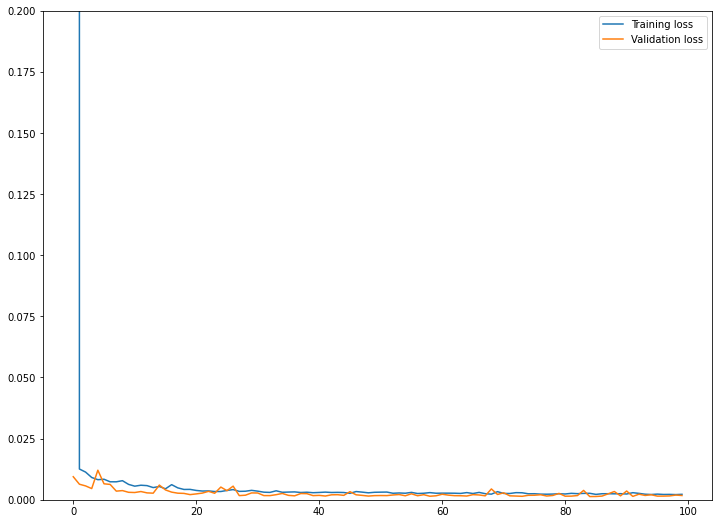

In [93]:
plt.figure(figsize=(12,9))
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Validation loss')
plt.ylim((0,0.2))
plt.legend()

In [41]:
reconstructed_model = keras.models.load_model("./Avg_p_model")

In [42]:
forecast1 = reconstructed_model.predict(trainX[-50:])

In [43]:
forecast1.shape

(50, 8)

In [44]:
forecast = forecast1[:,1]

In [58]:
y_pred = scaler.inverse_transform(forecast1)

In [59]:
y_pred = y_pred[:,1]

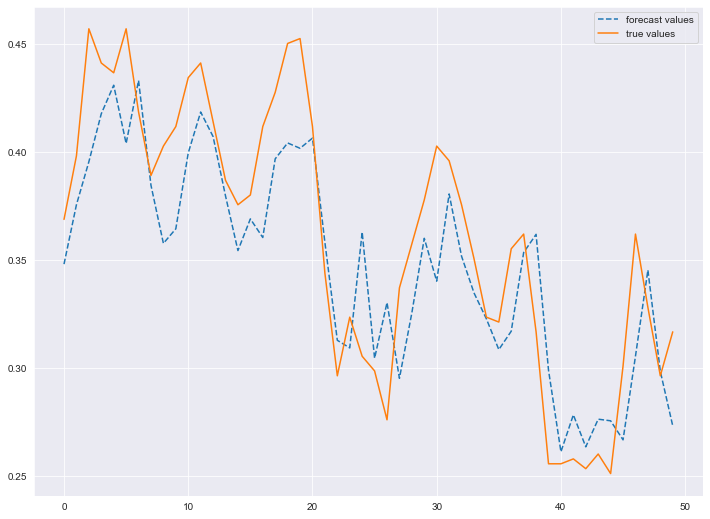

In [45]:
plt.figure(figsize=(12,9))
sns.set_style("darkgrid")
plt.plot(forecast,linestyle="--",label="forecast values")
plt.plot(trainY[-50:],label="true values")
plt.legend()

### Making future predictions

In [118]:
# model.save("Avg_p_model")

INFO:tensorflow:Assets written to: Avg_p_model\assets


In [4]:
reconstructed_model = keras.models.load_model("Avg_p_model")

In [12]:
trainX[-1:]

array([[[0.91186441, 0.25339367, 0.14567901, 0.40361446, 0.88297872,
         0.90460526, 0.61445783, 0.12733403],
        [0.91186441, 0.260181  , 0.15308642, 0.3935743 , 0.93262411,
         0.91118421, 0.5060241 , 0.12468134],
        [0.89152542, 0.25113122, 0.13333333, 0.40763052, 0.93262411,
         0.86513158, 0.62650602, 0.12218114],
        [0.77966102, 0.30090498, 0.19506173, 0.43172691, 0.84042553,
         0.72697368, 0.75903614, 0.11983592],
        [0.85423729, 0.36199095, 0.24691358, 0.50401606, 0.83333333,
         0.83223684, 0.69879518, 0.11764732],
        [0.84745763, 0.3280543 , 0.24444444, 0.46385542, 0.85460993,
         0.81578947, 0.72289157, 0.11561487],
        [0.86779661, 0.29638009, 0.18024691, 0.437751  , 0.89361702,
         0.81578947, 0.74698795, 0.11373762]]])

In [13]:
forecast = reconstructed_model.predict(trainX[-1:])

In [14]:
forecast

array([[0.27415234, 0.273202  , 0.27332965, 0.27395585, 0.27336752,
        0.27528194, 0.27296445, 0.2737131 ]], dtype=float32)

In [169]:
forecast[0][0][1]

0.273202

### Function to predict future values

In [46]:
future_predictions = []  ## list of future values

current_batch = trainX[-1:]   ## using the last 7 days of past to predict the next future day

for _ in range(14):    ## iterating the same for 14 days future forecast
    
    # get the prediction value for the first batch
    current_pred = reconstructed_model.predict(current_batch)
    
    print("Current_pred: {}".format(current_pred))
    # append the prediction into the array
    future_predictions.append(current_pred[0][1])
    
    # use the prediction to update the batch and remove the first value
    current_batch= np.delete(current_batch,0,axis=1)
    current_pred = current_pred.reshape((1,1,8))
    current_batch = np.append(current_batch,current_pred,axis=1)
    
    print("Current_batch: {}".format(current_batch))

Current_pred: [[0.27415234 0.273202   0.27332965 0.27395585 0.27336752 0.27528194
  0.27296445 0.2737131 ]]
Current_batch: [[[0.91186441 0.260181   0.15308642 0.3935743  0.93262411 0.91118421
   0.5060241  0.12468134]
  [0.89152542 0.25113122 0.13333333 0.40763052 0.93262411 0.86513158
   0.62650602 0.12218114]
  [0.77966102 0.30090498 0.19506173 0.43172691 0.84042553 0.72697368
   0.75903614 0.11983592]
  [0.85423729 0.36199095 0.24691358 0.50401606 0.83333333 0.83223684
   0.69879518 0.11764732]
  [0.84745763 0.3280543  0.24444444 0.46385542 0.85460993 0.81578947
   0.72289157 0.11561487]
  [0.86779661 0.29638009 0.18024691 0.437751   0.89361702 0.81578947
   0.74698795 0.11373762]
  [0.27415234 0.273202   0.27332965 0.27395585 0.27336752 0.27528194
   0.27296445 0.27371311]]]
Current_pred: [[0.2691487  0.26783466 0.26804158 0.2687964  0.26793855 0.27004895
  0.26751855 0.26840127]]
Current_batch: [[[0.89152542 0.25113122 0.13333333 0.40763052 0.93262411 0.86513158
   0.62650602 0.12

Current_pred: [[0.5633567  0.55977094 0.5610701  0.56361544 0.5607853  0.5611415
  0.5606092  0.5621637 ]]
Current_batch: [[[0.25263119 0.25112653 0.25151989 0.25227508 0.25116158 0.25332728
   0.25078514 0.25177372]
  [0.29542226 0.29346323 0.29396006 0.29510596 0.29363805 0.29553494
   0.2932491  0.29444021]
  [0.35123652 0.34875613 0.34943071 0.35101554 0.34911489 0.35064247
   0.34874031 0.35014266]
  [0.42040712 0.41726506 0.4181582  0.42028531 0.41784447 0.41894689
   0.41748652 0.41914648]
  [0.48341185 0.47983432 0.48090872 0.48340723 0.48061061 0.48135331
   0.48029032 0.4820714 ]
  [0.53395259 0.5301916  0.53142178 0.53408074 0.53112149 0.53159773
   0.53086627 0.53262377]
  [0.5633567  0.55977094 0.56107008 0.56361544 0.56078529 0.56114149
   0.56060922 0.56216371]]]


### Inverse Scaling

In [47]:
future_predictions

[0.273202,
 0.26783466,
 0.24148887,
 0.22362524,
 0.22082472,
 0.2191081,
 0.2245701,
 0.25112653,
 0.29346323,
 0.34875613,
 0.41726506,
 0.47983432,
 0.5301916,
 0.55977094]

In [48]:
new = np.asarray(future_predictions,dtype=np.float64)

In [50]:
new  = new.reshape((14,1))

In [51]:
new.shape

(14, 1)

In [52]:
prediction_copies = np.repeat(new, 8, axis=1)

In [53]:
prediction_copies.shape

(14, 8)

In [54]:
y_pred_future = scaler.inverse_transform(prediction_copies)

In [55]:
y_pred_future = y_pred_future[:,1]

In [56]:
y_pred_future

array([ 9951.75528491,  9949.38292122,  9937.73808229,  9929.84235728,
        9928.60452557,  9927.84578228,  9930.25998223,  9941.99792528,
        9960.71074772,  9985.15021145, 10015.43115544, 10043.08676863,
       10065.34468734, 10078.41875625])

In [186]:
len(trainY[-7:])

7

### Predictions for 10 days

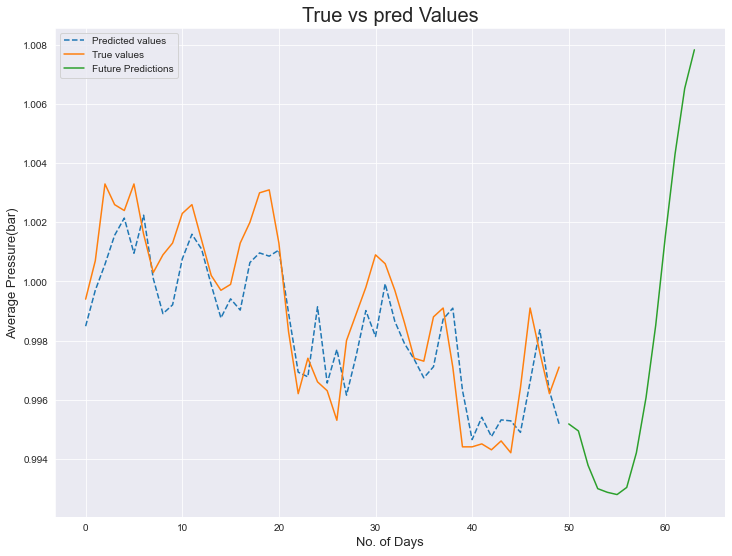

In [60]:
plt.figure(figsize=(12,9))
sns.set_style("darkgrid")
plt.title("True vs pred Values",fontsize=20)
plt.xlabel("No. of Days",fontsize=13)
plt.ylabel("Average Pressure(bar)",fontsize=13)
plt.plot(y_pred/10000,linestyle="--",label="Predicted values")
plt.plot(df_for_training[-50:].AVGP.to_numpy()/10000,label= "True values")
plt.plot(len(trainY[-50:])+np.arange(0,14,1),y_pred_future/10000,label="Future Predictions")
plt.legend()
# plt.xlim((290,310))

In [61]:
from sklearn.metrics import mean_squared_error

In [73]:
y_pred/10000

array([0.99848485, 0.9997002 , 1.000579  , 1.0015618 , 1.0021453 ,
       1.0009534 , 1.0022428 , 1.0000986 , 0.99890965, 0.9992078 ,
       1.0007596 , 1.0015974 , 1.001095  , 0.9998808 , 0.9987626 ,
       0.99941045, 0.9990299 , 1.0006391 , 1.0009648 , 1.0008552 ,
       1.0010633 , 0.99893075, 0.9969268 , 0.9967707 , 0.99914044,
       0.99655926, 0.99769676, 0.9961485 , 0.9974884 , 0.9990135 ,
       0.9981359 , 0.9999206 , 0.9986474 , 0.99789786, 0.99736506,
       0.99673635, 0.9971125 , 0.99872285, 0.99909455, 0.99631584,
       0.9946451 , 0.9954017 , 0.99474716, 0.9953126 , 0.9952796 ,
       0.99488974, 0.99660164, 0.99836326, 0.996292  , 0.9951755 ],
      dtype=float32)

In [74]:
df_for_training[-50:].AVGP.to_numpy()/10000

array([0.9994, 1.0007, 1.0033, 1.0026, 1.0024, 1.0033, 1.0016, 1.0003,
       1.0009, 1.0013, 1.0023, 1.0026, 1.0014, 1.0002, 0.9997, 0.9999,
       1.0013, 1.002 , 1.003 , 1.0031, 1.0013, 0.9983, 0.9962, 0.9974,
       0.9966, 0.9963, 0.9953, 0.998 , 0.9989, 0.9998, 1.0009, 1.0006,
       0.9997, 0.9986, 0.9974, 0.9973, 0.9988, 0.9991, 0.9971, 0.9944,
       0.9944, 0.9945, 0.9943, 0.9946, 0.9942, 0.9964, 0.9991, 0.9976,
       0.9962, 0.9971])

In [72]:
mean_squared_error(df_for_training[-50:].AVGP.to_numpy()/10000,y_pred/10000)

2.029353399611964e-06

### EMD

In [49]:
import emd

imf = emd.sift.sift(df_for_training.AVGP.to_numpy())

<AxesSubplot:xlabel='Time (samples)'>

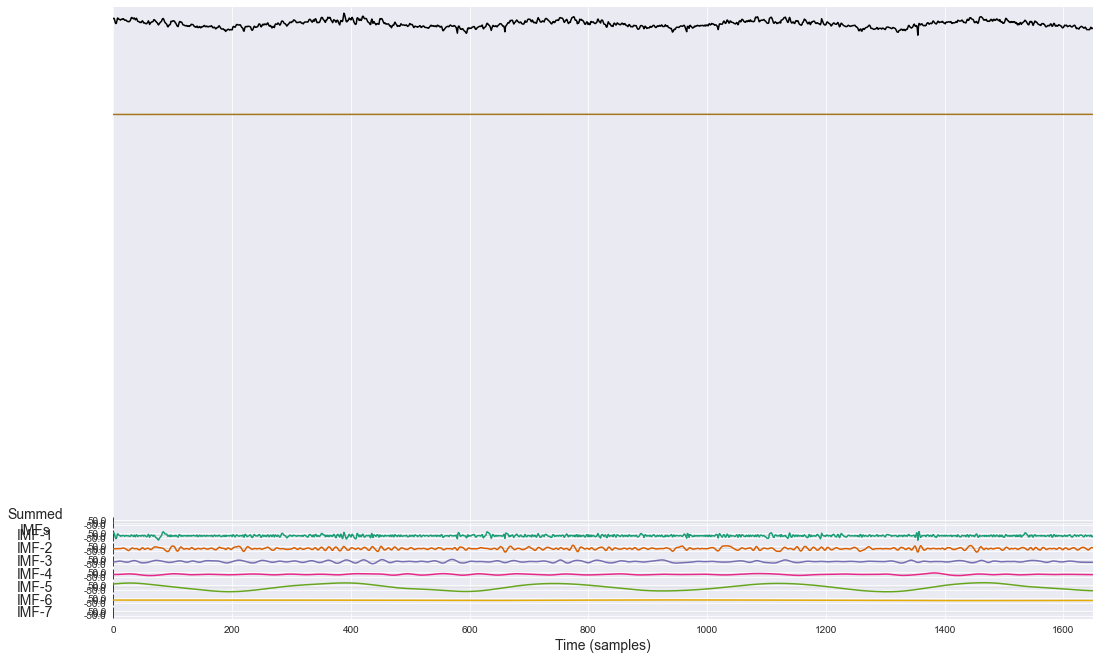

In [55]:
emd.plotting.plot_imfs(imf)

In [59]:
type(imf)

numpy.ndarray

In [71]:
new_df = pd.DataFrame(imf,columns=["imf_1","imf_2","imf_3","imf_4","imf_5","imf_6","imf_7"])

In [72]:
new_df["avg_p"] = df_for_training.AVGP

<AxesSubplot:>

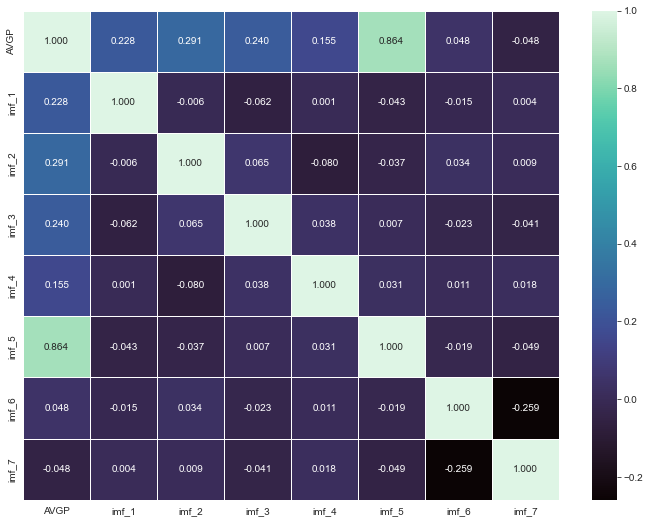

In [30]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,9))
sns.heatmap(imf.corr('pearson'),cmap="mako",fmt='.3f',annot = True,linewidths=0.5,linecolor="white")

### KMO Test

In [80]:
def kmo(dataset_corr):
    
    import numpy as np
    import math as math
    import collections
    
    r"""
    
    Parameters
    ----------
    dataset_corr : ndarray
        Array containing dataset correlation
        
    Returns
    -------
    out : namedtuple
        The function outputs the test value (value), the test value per variable (per_variable)
       
        Ex:
        Out[30]: 
        KMO_Test_Results(value=0.798844102413, 
        per_variable=
        Q1     0.812160468405
        Q2     0.774161264483
        Q3     0.786819432663
        Q4     0.766251123086
        Q5     0.800579196084
        Q6     0.842927745203 
        Q7     0.792010173432 
        Q8     0.862037322891
        Q9     0.714795031915 
        Q10    0.856497242574
        dtype: float64)
    
    References
    ----------    
    [1] Kaiser, H. F. (1970). A second generation little jiffy. Psychometrika, 35(4), 401-415.
    [2] Kaiser, H. F. (1974). An index of factorial simplicity. Psychometrika, 39(1), 31-36.
    [3] R. Sarmento and V. Costa, (2017)
    "Comparative Approaches to Using R and Python for Statistical Data Analysis", IGI-Global
    
    Examples
    --------
    illustration how to use the function.
    
    >>> kmo_test(survey_data.corr(method="spearman"))
         
        KMO_Test_Results(value=0.798844102413, 
        per_variable=
        Q1     0.812160468405
        Q2     0.774161264483
        Q3     0.786819432663
        Q4     0.766251123086
        Q5     0.800579196084
        Q6     0.842927745203 
        Q7     0.792010173432 
        Q8     0.862037322891
        Q9     0.714795031915 
        Q10    0.856497242574
        dtype: float64) 
"""
    
    

    #KMO Test
    #inverse of the correlation matrix
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    
    #partial correlation matrix
    A = np.ones((nrow_inv_corr,ncol_inv_corr))
    for i in range(0,nrow_inv_corr,1):
        for j in range(i,ncol_inv_corr,1):
          #above the diagonal
            A[i,j] = - (corr_inv[i,j]) / (math.sqrt(corr_inv[i,i] * corr_inv[j,j]))
          #below the diagonal
            A[j,i] = A[i,j]
    
  #transform to an array of arrays ("matrix" with Python)
    dataset_corr = np.asarray(dataset_corr)
        
  #KMO value
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(dataset_corr)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    
    
    kmo_j = [None]*dataset_corr.shape[1]
  #KMO per variable (diagonal of the spss anti-image matrix)
    for j in range(0, dataset_corr.shape[1]):
        kmo_j_num = np.sum(dataset_corr[:,[j]] ** 2) - dataset_corr[j,j] ** 2
        kmo_j_denom = kmo_j_num + np.sum(A[:,[j]] ** 2) - A[j,j] ** 2
        kmo_j[j] = kmo_j_num / kmo_j_denom

    
    Result = collections.namedtuple("KMO_Test_Results", ["value", "per_variable"])   
    
  #Output of the results - named tuple    
    return Result(value=kmo_value,per_variable=kmo_j)

In [81]:
kmo(df_for_training.corr(method="spearman"))

KMO_Test_Results(value=0.8444983451921596, per_variable=[0.785913792306106, 0.7880226343045621, 0.853485260542759, 0.8682384876552263, 0.8402332595711512, 0.8408183172991415, 0.7035338907953588, 0.9893852630630727])